# Quantum Kernel Estimator Challenge

For the first leg of the QML challenge, you implemented a variational quantum classifier (VQC) to take on a supervised learning problem based on the work of [Havlicek et al. (2018)](https://arxiv.org/pdf/1804.11326.pdf). Now, you will build on that experience, and explore Havlicek et al.'s second proposed method of applying quantum-enhanced feature spaces to machine learning: the *quantum kernel estimator*. In this challenge continuation, you will construct a QML model that estimates a kernel function using a quantum computer and optimize a classical support vector machine (SVM). For this classification protocol, we will continue to restrict ourselves to the binary label case, with $C = \left\{+1, −1\right\}$.

Compared to the VQC challenge, we are providing very little template code for this kernel estimator challenge. This is by design to enable teams to further differentiate their model, especially in the training phase. The [Havlicek et al. (2018)](https://arxiv.org/pdf/1804.11326.pdf) paper is your best resource, and the [Kernel-based training Pennylane tutorial](https://pennylane.ai/qml/demos/tutorial_kernel_based_training.html) may also be helpful. You are free to import and use any additional packages that you wish.

In [14]:
#!qbraid jobs enable haqs  # enable quantum jobs

In [15]:
TEAM_NAME = "EXP"  # enter team name

In [16]:
import warnings

warnings.filterwarnings("ignore")

import csv
import json
import os
import time
from itertools import chain, combinations

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import pennylane as qml
import pennylane.numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

from scipy.optimize import minimize

 
import cvxopt as opt
from cvxopt import matrix, spmatrix, sparse
from cvxopt.solvers import qp, options
from cvxopt import blas

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


## Load and visualize dataset

As before, we are given data from a training set $T$ and a test set $S$ of a subset $\Omega \in \rm {I\!R}^n$. Both are assumed to be labelled by the map $m: T \cup S \rightarrow \{+1, −1\}$ unkown to the algorithm. To generate the data, two random vectors in the X-Z plane of the Bloch sphere are chosen. Around these two vectors, we randomly sample two sets of quantum data points; the task is to learn to distinguish the two sets.

[[1.         0.44879427 0.66421857 ... 0.29931935 0.36221329 0.24579391]
 [0.44879427 1.         0.1914939  ... 0.95520734 0.84624496 0.21566963]
 [0.66421857 0.1914939  1.         ... 0.0887313  0.19800538 0.37011697]
 ...
 [0.29931935 0.95520734 0.0887313  ... 1.         0.89501368 0.29472253]
 [0.36221329 0.84624496 0.19800538 ... 0.89501368 1.         0.23022383]
 [0.24579391 0.21566963 0.37011697 ... 0.29472253 0.23022383 1.        ]]
     pcost       dcost       gap    pres   dres
 0: -1.0964e+01 -2.8910e+01  8e+01  7e+00  2e+00
 1: -1.5993e+01 -2.6512e+01  1e+01  9e-01  2e-01
 2: -2.0922e+01 -2.4236e+01  4e+00  6e-02  2e-02
 3: -2.2261e+01 -2.2925e+01  7e-01  1e-02  3e-03
 4: -2.2644e+01 -2.2710e+01  7e-02  3e-05  8e-06
 5: -2.2687e+01 -2.2688e+01  2e-03  5e-07  1e-07
 6: -2.2688e+01 -2.2688e+01  2e-05  5e-09  1e-09
 7: -2.2688e+01 -2.2688e+01  2e-07  5e-11  1e-11
Optimal solution found.
Prediction accuracy is: 100.0%.


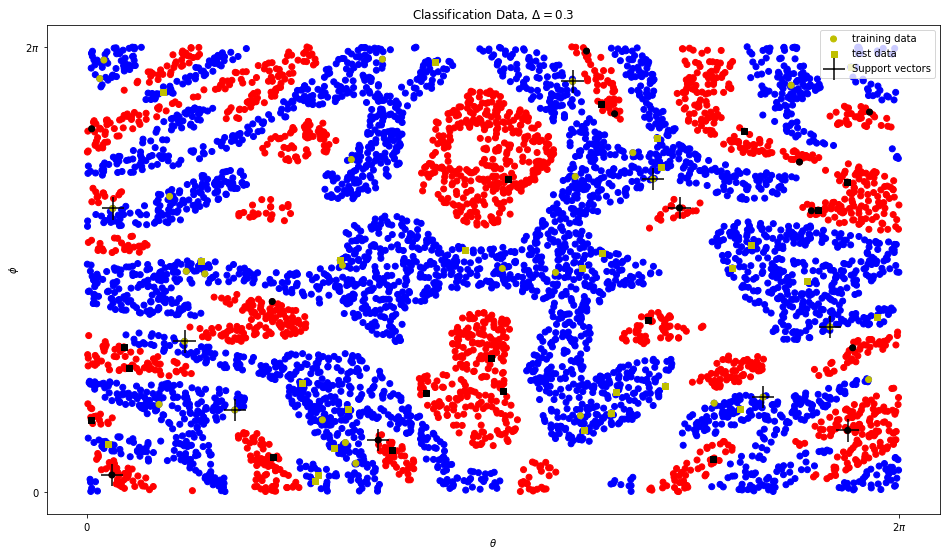

In [17]:
%run gen_binary_rz.py  # uncomment to generate new train/test dataset

DATA_PATH = "data/"

file = open(DATA_PATH + "params.json")

params = json.load(file)
delta = params["delta"]
n_points = params["n_points"]

file.close()

# Load data
Xs = np.zeros(shape=(n_points, 2))
Ys = np.zeros(shape=(n_points,))

with open(DATA_PATH + "binary_data.csv", mode="r") as file:
    csvFile = csv.reader(file)
    for i, row in enumerate(csvFile):
        Xs[i] = np.array([float(row[0]), float(row[1])])
        Ys[i] = float(row[2])
        if i == n_points:
            break

n_sets = 2
samples_per_set = 40
n_samples = n_sets * samples_per_set
X_data, Y_data = Xs[:n_samples], Ys[:n_samples]
X_train, X_test, Y_train, Y_test = train_test_split(
    X_data, Y_data, train_size=1 / n_sets
)


def powerset(iterable, mx):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    pset = chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))
    return [l for l in list(pset) if len(l) == mx]
def encode_data(x):
    """Non-linear encoding (transformation) of one input data vector

    Args:
        x : shape (2,) tensor containing one input data vector

    Returns:
        triple of data encoded coefficients phi_1, phi_2, phi_{1,2}
    """

    return x[0], x[1], (np.pi - x[0]) * (np.pi - x[1])
# functionality within the class as a attribute.
n_wires = 2  # number of qubits
S_size = 2  # number of interactions considered
pset = powerset(range(n_wires), S_size)
def embedding(x):
    """The embedding ansatz

    Args:
        x : shape (3,) tensor containing one encoded data vector

    """
    ## @pafloxy 
    for w in range(n_wires):
        qml.RZ(2 * x[w], wires= w)
    for w in pset:
        qml.CNOT(wires= w)
        qml.RZ(2 * x[2], wires= w[1])    
        qml.CNOT(wires= w)
    
dev_kernel = qml.device("default.qubit", wires=n_wires)

projector = np.zeros((2**n_wires, 2**n_wires))
projector[0, 0] = 1


@qml.qnode(dev_kernel)
def kernel(x, z):
    """Compute quantum kernel element for two feature vectors.

    Args:
        x : shape (2,) tensor containing one input data vector
        z : shape (2,) tensor containing one input data vector
    
    Returns: |<0|feature_map(z)^daggered feature_map(x)|0>|^2 calculated via mat multiplication 

    """

    x_enc = encode_data(x)
    z_enc = encode_data(z)

    for _ in range(S_size):
        for i in range(n_wires):
            qml.Hadamard(wires=i)
        embedding(x_enc)

    for _ in range(S_size):
        qml.adjoint(embedding)(z_enc)
        for i in range(n_wires):
            qml.Hadamard(wires=i)

    return qml.expval(qml.Hermitian(projector, wires=range(n_wires)))
def kernel_ideal(A, B):
    """Ideal kernel matrix for sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A])
# evaluate k_ideal
# takes about a minute or two to evaluate completely
k_ideal = kernel_ideal(X_train, X_train)  
# Visualize ideal kernel matrix containing the inner products of all
# data points used for training, c.f. Havlicek Fig. 4.a (right)

from typing import Callable# might be deprecated for the latest version. 
class support_vector_classifier():
    """
    A class to implement SVC for the given classification problem  
    
    """

    def __init__(self, fidelity_calc_fun: Callable ) -> None :
        
        self.fidelity_estimate = fidelity_calc_fun ## function to calculate fidelity between elements
    
    def find_kernel_matrix(self, A, B) -> np.array :
        """ 
        Calculates elements of the kernel matrix for the given inputs
        """

        return np.array([[self.fidelity_estimate(i, j) for j in B] for i in A])
        

    def train_svc(self, x_train: np.array, y_train: np.array):
        """
        Formulates the Dual problem to find necessary coefficents and solves it using 'cvxopt' tools

        ARGS:
        ----
        x_train : an array containing all training data (X)
        y_train : an array containing all training labels (Y)


        RETURNS:
        -------
        support_vec_indices : array containing indices of the 'x_train' that correspond to the support vectors
        support_vec_alphas : array of positive 'alpha' coefficient corresponding to the support vectors 
        support_vec_ : array of support vectors
        b_estimates : estimate 'b' parameter for the classification step
        
        """
        ## load trainig data ##
        self.x_train = x_train
        self.y_train = y_train
        self.training_set_size = len(y_train)

        n = self.training_set_size

        self.kernel_matrix = self.find_kernel_matrix(x_train, x_train)
        quadratic_term = np.zeros((n,n))

        print(self.kernel_matrix) ## checkflag
        ## formulate quadratic problem ##
        for i in range(n):
            for j in range(n):
                quadratic_term[i,j] = self.kernel_matrix[i,j] * self.y_train[i] * self.y_train[j]

        quadratic_term = (0.5) * quadratic_term     ## quadrtic term
        linear = -1 * np.ones(n)        ## linear term

        A = matrix(self.y_train).T  ## add constraints
        B = matrix(0.0)
        G = matrix(-1* np.eye(n))  ## add constraints
        H = matrix(np.zeros(n))

        sol = qp(matrix(quadratic_term), matrix(linear), G, H, A, B)

        alphas = np.array(sol['x'])

        ## extract information regarding support vectors ##
        c = 0.00001  # TODO: make this inequality param tunable
        self.support_vec_indices = [ i for i in range(len(alphas)) if alphas[i] > c]
        self.support_vec_alphas =  [ (i, alphas[i]) for i in range(len(alphas)) if alphas[i] > c ] 
        self.support_vec_ =  [ (i, self.x_train[i]) for i in range(len(alphas)) if alphas[i] > c ] 
        
        ## estimate 'b' parameter for the classifier ##
        b_estimates = [y_train[j] - np.sum([ self.y_train[i] * alphas[i] * self.fidelity_estimate(self.x_train[i] , self.x_train[j]) for i in range(n)]) for j in self.support_vec_indices] 
        self.b = np.mean(b_estimates)

        return self.support_vec_indices, self.support_vec_alphas, self.support_vec_, b_estimates

    def predict_svc(self, x_test_elem):
        """ 
        Function to predict class of given input 

        ARGS:
        ----
        x_test_elem  :  single input data 

        
        RETURNS:
        -------
        y_label_elem : predicted output label

        """
        estimate = np.sum([  self.y_train[index] * alpha * self.fidelity_estimate(self.x_train[index], x_test_elem) for index, alpha in self.support_vec_alphas ]) + self.b
        y_label_elem = np.sign(estimate)

        return y_label_elem



        
svc_ideal = support_vector_classifier(kernel) ## train using ideal kernel estimator
res_ideal = svc_ideal.train_svc(X_train, Y_train)

prediction_ideal = [(svc_ideal.predict_svc(X_test[j]) == Y_test[j] ) for j in range(len(Y_test))]
acc_ideal = prediction_ideal.count(True) / len(Y_test) * 100
print(f"Prediction accuracy is: {acc_ideal*1}%.")   ## takes around 2 min

# # svc_sklrn = SVC(kernel= kernel_ideal, C = 100000.0)
# # svc_sklrn = svc_sklrn.fit(X_train, Y_train)

# # prediction_sklrn = svc_sklrn.predict(X_test)
# # prediction_sklrn = [ prediction_sklrn[i]==Y_test[i] for i in range(len(Y_test))]
# # acc_sklrn = prediction_sklrn.count(True) / len(Y_test) * 100
# # print(f"Prediction accuracy is: {acc_sklrn}%.")    ## takes around 3 min

# # set(res_ideal[0])

# preds = prediction_ideal   # change with {prediction_exp, prediction_sklrn , prediction_ideal}
# n_correct = preds.count(True)
# n_incorrect = preds.count(False)

# Plot predictions
# preds_png = f"{VQC_OUT}/{TEAM_NAME}_preds.png"

split_xs = lambda x: [[x[i][j] for i in range(len(x))] for j in [0, 1]]
xi_sv , xj_sv = split_xs([X_train[i] for i in res_ideal[0] ])  ## change res_exp[0] with {res_exp[0], res_exp[1], svc_sklrn.support_  }

xi, xj = split_xs(Xs)
xi_train, xj_train = split_xs(X_train)
xi_test, xj_test = split_xs(X_test)

label_circle = mlines.Line2D(
    [],
    [],
    color="none",
    marker="o",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Train ({len(X_train)})",
)
label_square = mlines.Line2D(
    [],
    [],
    color="none",
    marker="s",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Test ({len(X_test)})",
)

plt.figure(figsize=(16,9))
plt.scatter(xi, xj, marker="o", c=["r" if v == 1.0 else "b" for v in Ys])
plt.scatter(xi_train, xj_train, c=["k" if v == 1.0 else "y" for v in Y_train], label="training data")
plt.scatter(xi_test, xj_test, marker="s", c=["k" if v == 1.0 else "y" for v in Y_test], label="test data")
plt.scatter(xi_sv, xj_sv, s= [500]*len(xj_sv) , marker="+", c = "k", label="Support vectors" )  ## the green markers indicate the support-vectors
plt.xticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.yticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.xlabel("$\\theta$")
plt.ylabel("$\phi$")
#plt.legend(handles=[label_circle, label_square], loc="upper right")
plt.legend()
plt.title(f"Classification Data, $\Delta = {delta}$")
plt.show()

In [18]:
len(res_ideal[0]), len(X_train)

(11, 40)